Análise de Expressão Gênica do Conjunto GSE75688Este notebook realiza a análise de dados de expressão gênica do conjunto de dados GSE75688. O fluxo inclui:
1. Download dos dados do NCBI GEO
2. Carregamento e pré-processamento dos dados
3. Filtragem de células de interesse (células não tumorais)
4. Seleção de genes altamente variáveis e normalização logarítmica
5. Geração de arquivo de dados para COP-KMeans
6. Geração de restrições Must-Link (ML) e Cannot-Link (CL) com base em rótulos disponíveis
7. Execução do algoritmo COP-KMeans
8. Avaliação dos clusters usando NMI e visualizações (PCA e UMAP)

## 1. Download dos DadosAntes de executar as demais células, execute os comandos abaixo no terminal para baixar os arquivos:

In [1]:
# Download data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75688
!python -V
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_final_sample_information.txt.gz

Python 3.11.12
--2025-06-03 14:31:54--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10799212 (10M) [application/x-gzip]
Saving to: ‘GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz’

GSE75688_GEO_proces 100%[===================>]  10.30M  15.8MB/s    in 0.7s    

2025-06-03 14:31:55 (15.8 MB/s) - ‘GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz’ saved [10799212/10799212]

--2025-06-03 14:31:55--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_final_sample_information.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp

## 2. Importações

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Carregamento e Análise dos Dados

In [4]:
try:
    from run_ckm import run
except ImportError:
    print("Erro: Não foi possível importar a função 'run' de 'run_ckm.py'.")
    print("Por favor, verifique se os arquivos 'cop_kmeans.py' e 'run_ckm.py' foram carregados corretamente.")

In [5]:
# Carregar dados
info = pd.read_csv('GSE75688_final_sample_information.txt.gz', sep='\t')
matrix = pd.read_csv('GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz', sep='\t', index_col=0)

sc_cells = info[ info['type'] != 'Tumor' ]
missing = set(sc_cells['sample']) - set(matrix.columns)
print("Células presentes no info mas ausentes na matriz:", missing)
valid_cells = [cell for cell in sc_cells['sample'] if cell in matrix.columns]
matrix = matrix.loc[:, valid_cells]
sc_cells = sc_cells[sc_cells['sample'].isin(valid_cells)]

Células presentes no info mas ausentes na matriz: {'BC07_Pooled'}


In [6]:
# Seleção de genes altamente variáveis (HVG)
gene_var = matrix.var(axis=1)
top_genes = gene_var.sort_values(ascending=False).head(500).index
matrix_hvg = matrix.loc[top_genes]

data_log = np.log1p(matrix_hvg.T.values)
cells = matrix_hvg.columns.tolist()

np.savetxt('genes.data', data_log, fmt='%.4f')
print("Arquivo genes.data gerado.")

Arquivo genes.data gerado.


In [7]:
# Gerar restrições ML/CL
labels = sc_cells.set_index('sample').loc[cells, 'index3']
unique_types = labels.unique()
ml_pairs = []
cl_pairs = []
rng = np.random.default_rng(42)
for t in unique_types:
    idx = np.where(labels == t)[0]
    if len(idx) > 1:
        pairs = rng.choice(idx, size=min(20, len(idx)), replace=False)
        for i in range(len(pairs)//2):
            ml_pairs.append((pairs[2*i], pairs[2*i+1]))
for i, t1 in enumerate(unique_types):
    for t2 in unique_types[i+1:]:
        idx1 = np.where(labels == t1)[0]
        idx2 = np.where(labels == t2)[0]
        for _ in range(5):
            if idx1.size > 0 and idx2.size > 0:
                a = rng.choice(idx1)
                b = rng.choice(idx2)
                cl_pairs.append((a, b))

with open('genes.constraints', 'w') as f:
    for (i,j) in ml_pairs:
        f.write(f'{i} {j} 1\n')
    for (i,j) in cl_pairs:
        f.write(f'{i} {j} -1\n')
print("Arquivo genes.constraints gerado no formato correto.")

Arquivo genes.constraints gerado no formato correto.


In [13]:
# Rodar COP-KMeans
print("\nRodando COP-KMeans...")
k = len(unique_types)
clusters = run(datafile='genes.data', consfile='genes.constraints', k=k,
               n_rep=10, max_iter=300, tolerance=1e-4)

if clusters is None:
    print("COP-KMeans não encontrou uma solução com as restrições fornecidas.")
else:
    print("COP-KMeans concluído.")
    true_labels = labels.values
    clusters_np = np.array(clusters)
    if np.array_equal(clusters_np, true_labels):
        print("\nAtenção: Os clusters do COP-KMeans são IDÊNTICOS aos rótulos verdadeiros (index3).")
    else:
        print("\nOs clusters do COP-KMeans NÃO são idênticos aos rótulos verdadeiros (index3).")
    nmi = normalized_mutual_info_score(true_labels, clusters)
    print(f'\033[1mNMI obtido (COP-KMeans):\033[0m {nmi:.4f}')



Rodando COP-KMeans...
COP-KMeans concluído.

Os clusters do COP-KMeans NÃO são idênticos aos rótulos verdadeiros (index3).
NMI obtido (COP-KMeans): 0.4615



Realizando Redução de Dimensionalidade (UMAP) e Visualização...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


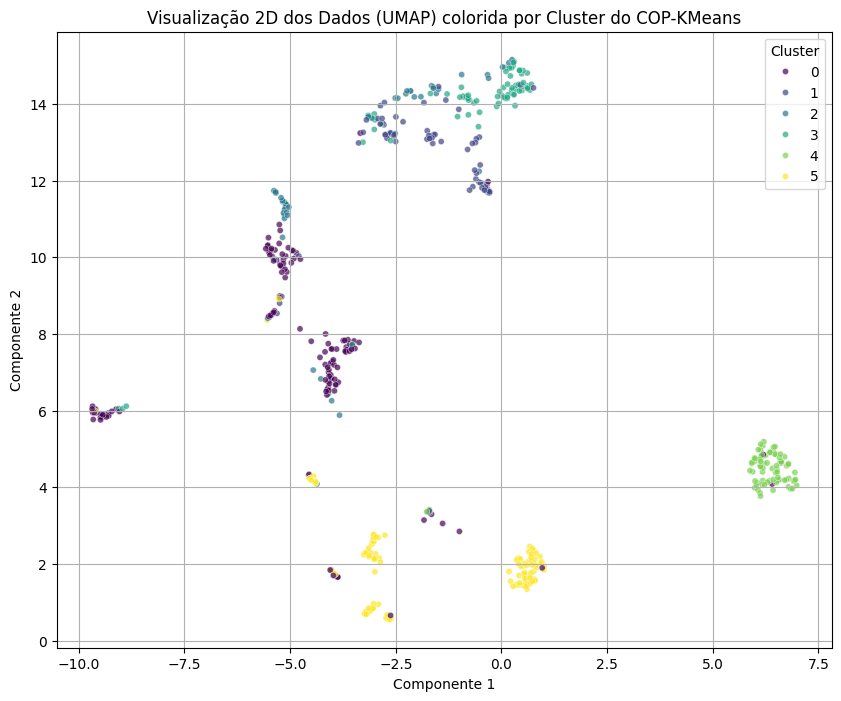

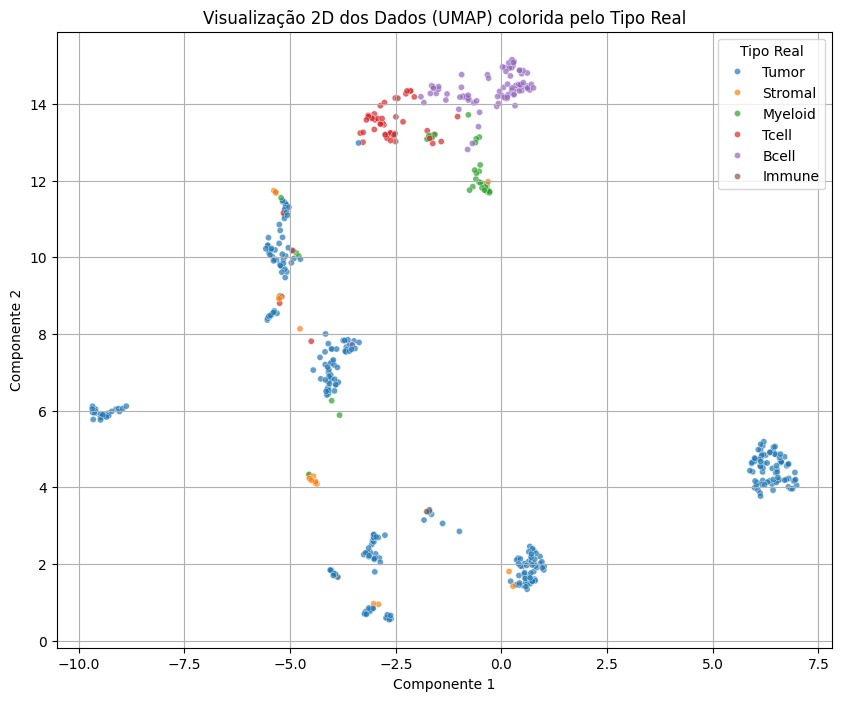

Visualizações geradas.


In [10]:
# Redução de dimensionalidade e visualização
print("\nRealizando Redução de Dimensionalidade (UMAP) e Visualização...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
data_reduced = reducer.fit_transform(data_log)

plot_df = pd.DataFrame(data_reduced, columns=['Componente 1', 'Componente 2'])
plot_df['Cluster'] = clusters
plot_df['Tipo Real'] = true_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Componente 1', y='Componente 2', hue='Cluster', data=plot_df,
                palette='viridis', s=20, alpha=0.7)
plt.title('Visualização 2D dos Dados (UMAP) colorida por Cluster do COP-KMeans')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='Componente 1', y='Componente 2', hue='Tipo Real', data=plot_df,
                palette='tab10', s=20, alpha=0.7)
plt.title('Visualização 2D dos Dados (UMAP) colorida pelo Tipo Real')
plt.grid(True)
plt.show()

print("Visualizações geradas.")